In [ ]:
!pip install openpyxl
import re
import random
import numpy as np
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# Load and process the dataset
data_path = "/content/drive/MyDrive/BrajT0HinidiiiEnglish/Data.xlsx"

# Define a function to load and clean data from Excel
import pandas as pd

df = pd.read_excel(data_path)

In [ ]:
df.head()

,Braj,Hindi,English
0,हमका कउनू मदद करब?,मुझे मदद करोगे?,Will you help me?
1,तू हमरा के कहां ले जाइब?,तुम मुझे कहाँ ले जाओगे?,Where are you going with me?
2,तू कहाँ रइहबा?,तुम कहाँ रह रहे हो?,Where are you living?
3,तू कहाँ मिलल बा?,तुम कहाँ मिल रहे हो?,Where are you meeting?
4,तोहरे भाई का का नाम बा?,तुम्हारे भाई का नाम क्या है?,What is your brother's name?


In [ ]:
# Clean the data
english_sentences = df['English'].apply(lambda x: " ".join(re.findall(r"[A-Za-z0-9]+", x)))
braj_sentences = df['Braj'].apply(lambda x: re.sub(r"%s|\|<|>|%|[a-z]|[A-Z]|_", '', x))

pairs = list(zip(english_sentences, braj_sentences))
random.shuffle(pairs)

# Prepare the token sets and sequences
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

In [ ]:
for pair in pairs:
    input_doc, target_doc = pair[0], pair[1]
    input_docs.append(input_doc)
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    target_doc = ' ' + target_doc + ' '
    target_docs.append(target_doc)

    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        input_tokens.add(token)
    for token in target_doc.split(" "):
        target_tokens.add(token)

In [ ]:
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", doc)) for doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", doc)) for doc in target_docs])

In [ ]:
# Initialize the encoder and decoder inputs
encoder_input_data = np.zeros((len(input_docs), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [ ]:
# Populate the encoder and decoder matrices
for i, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for t, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        encoder_input_data[i, t, input_features_dict[token]] = 1.0
    for t, token in enumerate(target_doc.split()):
        decoder_input_data[i, t, target_features_dict[token]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_features_dict[token]] = 1.0

In [ ]:
# Define the Seq2Seq model
dimensionality = 256
batch_size = 64
epochs = 1000

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

In [ ]:
# Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Model for training
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/1000
13/13 [==============================] - 5s 142ms/step - loss: 2.5932 - accuracy: 0.1034 - val_loss: 2.1717 - val_accuracy: 0.1123
Epoch 2/1000
13/13 [==============================] - 1s 73ms/step - loss: 1.9675 - accuracy: 0.1291 - val_loss: 1.8486 - val_accuracy: 0.1437
Epoch 3/1000
13/13 [==============================] - 1s 74ms/step - loss: 1.7816 - accuracy: 0.1429 - val_loss: 1.7824 - val_accuracy: 0.1437
Epoch 4/1000
13/13 [==============================] - 1s 73ms/step - loss: 1.7512 - accuracy: 0.1422 - val_loss: 1.7631 - val_accuracy: 0.1437
Epoch 5/1000
13/13 [==============================] - 1s 72ms/step - loss: 1.7259 - accuracy: 0.1430 - val_loss: 1.7416 - val_accuracy: 0.1455
Epoch 6/1000
13/13 [==============================] - 1s 72ms/step - loss: 1.7067 - accuracy: 0.1443 - val_loss: 1.7196 - val_accuracy: 0.1567
Epoch 7/1000
13/13 [==============================] - 1s 73ms/step - loss: 1.6886 - accuracy: 0.1524 - val_loss: 1.7047 - val_accuracy: 0.157

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


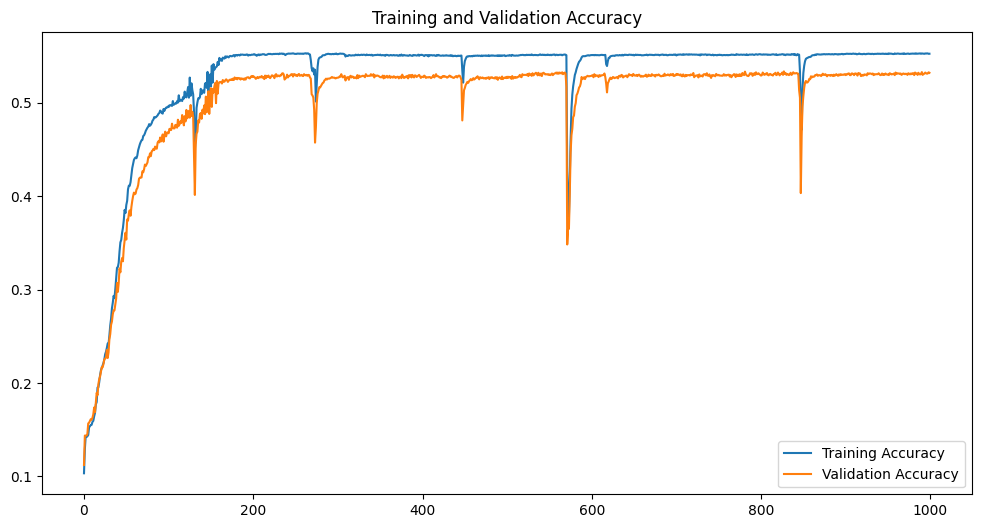

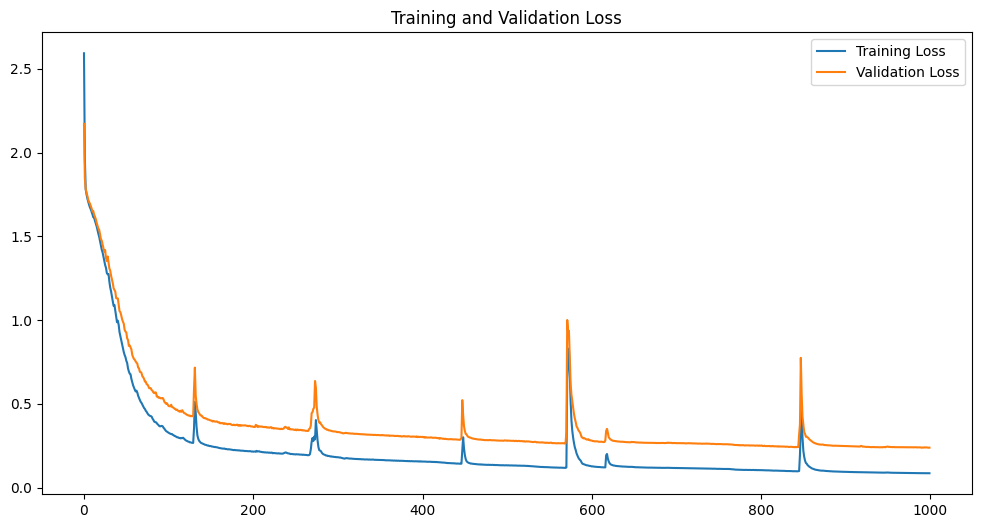

In [ ]:
# Save the model
training_model.save('braj_to_english_translation_model.h5')

# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

# Inference setup
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = dimensionality
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_features_dict['']] = 1.0

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += ' ' + sampled_token

        if sampled_token == '' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [hidden_state, cell_state]

    return decoded_sentence


In [ ]:
# Translator interface
class Translator:
    def start(self):
        user_input = input("Enter an English sentence to translate:\n")
        self.translate(user_input)

    def translate(self, sentence):
        translation = self.generate_response(sentence)
        print(f"Translation: {translation}")

    def string_to_matrix(self, sentence):
        tokens = re.findall(r"[\w']+|[^\s\w]", sentence)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.0
        return user_input_matrix

    def generate_response(self, sentence):
        input_matrix = self.string_to_matrix(sentence)
        response = decode_sequence(input_matrix)
        return response.strip()

# Instantiate and start the translator for one-time translation
translator = Translator()
translator.start()


Enter an English sentence to translate:
What is your brother's name?
1/1 [==============================] - 0s 26ms/step
Translation: ो ह ा र न ा व क ा ब ा


In [ ]:
# Inference setup
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = dimensionality
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1 with start token.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_features_dict['']] = 1.0  # assuming '' is the start token

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        # Predict the next token and the new states.
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Sample a token (get the index of the max probability).
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]

        # Append the token (not space-separated, but directly).
        decoded_sentence.append(sampled_token)

        # Exit condition: either hit the stop token or max length.
        if (sampled_token == '' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states.
        states_value = [hidden_state, cell_state]

    # Join tokens without space if they are characters, but you can adjust this based on your tokenization
    return ''.join(decoded_sentence).strip()  # Joining without spaces

# Translator interface
class Translator:
    def start(self):
        user_input = input("Enter an English sentence to translate:\n")
        self.translate(user_input)

    def translate(self, sentence):
        translation = self.generate_response(sentence)
        print(f"Translation: {translation}")

    def string_to_matrix(self, sentence):
        tokens = re.findall(r"[\w']+|[^\s\w]", sentence)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.0
        return user_input_matrix

    def generate_response(self, sentence):
        input_matrix = self.string_to_matrix(sentence)
        response = decode_sequence(input_matrix)
        return response.strip()

# Instantiate and start the translator for one-time translation
translator = Translator()
translator.start()


Enter an English sentence to translate:
Where are you living?
1/1 [==============================] - 0s 25ms/step
Translation: ूकहारहेब?ाााााााााााााा


In [ ]:
# Inference setup
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = dimensionality
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1 with start token.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_features_dict['']] = 1.0  # Assuming '' is the start token

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        # Predict the next token and the new states.
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Sample a token (get the index of the max probability).
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]

        # Add the sampled token to the decoded sentence.
        if sampled_token != '' and sampled_token != '?ाा':
            decoded_sentence.append(sampled_token)

        # Exit condition: either hit the stop token or max length.
        if sampled_token == '' or sampled_token == '?' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states.
        states_value = [hidden_state, cell_state]

    # Join tokens with space to form the final sentence
    return ' '.join(decoded_sentence).strip()

# Translator interface
class Translator:
    def start(self):
        user_input = input("Enter an English sentence to translate:\n")
        self.translate(user_input)

    def translate(self, sentence):
        translation = self.generate_response(sentence)
        print(f"Translation: {translation}")

    def string_to_matrix(self, sentence):
        tokens = re.findall(r"[\w']+|[^\s\w]", sentence)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.0
        return user_input_matrix

    def generate_response(self, sentence):
        input_matrix = self.string_to_matrix(sentence)
        response = decode_sequence(input_matrix)
        return response.strip()

# Instantiate and start the translator for one-time translation
translator = Translator()
translator.start()


Enter an English sentence to translate:
is 
1/1 [==============================] - 0s 25ms/step
Translation: ो ह ा र न े क करब ?
